In [ ]:
#The goal is to build a machine learning model to be used to predict the price
#However, this is so a user can tell from just the app if the price is a good value
#This means the columns will be limited to data readily available on the app.
#I am also going to remove descriptive text, like summary fopr example
#Adding this to a model is beyond thhe scope of this project

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import calendar and listings df
calendar_df = pd.read_csv('../Data/calendar.csv')
listings_df = pd.read_csv('../Data/listings.csv')

In [3]:
#Change index to allow merging
listings_df = listings_df.rename(index=str, columns={'id': 'listing_id'})
#And then merge
combined_df = pd.merge(calendar_df, listings_df, on = 'listing_id')

In [4]:
#Now to drop all the rows that do not have a price_x as this is our predictor
combined_df = combined_df.dropna(subset=['price_x'])

In [5]:
#Create a new dataframe of just the values I can use 
df = combined_df[['bathrooms','bedrooms','beds','date','host_total_listings_count',
                  'number_of_reviews','review_scores_rating','price_x']].copy()

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
date,date,0.000000
number_of_reviews,number_of_reviews,0.000000
price_x,price_x,0.000000
host_total_listings_count,host_total_listings_count,0.009844
beds,beds,0.039057
bedrooms,bedrooms,0.214330
bathrooms,bathrooms,0.513942
review_scores_rating,review_scores_rating,15.466079


In [7]:
df.dtypes

bathrooms                    float64
bedrooms                     float64
beds                         float64
date                          object
host_total_listings_count    float64
number_of_reviews              int64
review_scores_rating         float64
price_x                       object
dtype: object

In [8]:
#checklist
#1.Bathrooms, Bedrooms, and beds have some missing values. Simple thing is to replace with the mode
#2.host_total_listings_count, is missing less than 1%, take the mode
#3.review_scores_rating is missing quite a few values, will just take the mean
#4.number_of_reviews does not need any changes
#5.date has no mising values. nothing directly needs to be done
#6.Price needs to be converted to float and renamed
#6.create a new value that has the month extracted from date
#7.create a new value that is number of reviews * review scores rating

In [9]:
cols = ['bathrooms','bedrooms','beds','host_total_listings_count']
df[cols]=df[cols].fillna(df.mode().iloc[0])
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].mean())
df['date'] = pd.to_datetime(df['date'])
df['month_of_date'] = df['date'].dt.month
df['price'] = df[['price_x']].astype(str)
df['price'] = df[['price']].replace('[$, ]','',regex=True).astype(float)
df['engineered_review'] = df['number_of_reviews'] * df['review_scores_rating']
df['engineered_review_2'] = df['number_of_reviews'] * df['review_scores_rating'] * df['review_scores_rating']
df = df.drop(columns = ['date'])
df = df.drop(columns = ['price_x'])

In [10]:
X = df.drop(columns='price')
y = df[['price']]

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

In [11]:
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler() 

X_train = sc.fit_transform(X_train) 

X_test = sc.transform(X_test) 

In [12]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=100,
                            criterion='mse',
                            random_state=42,
                            n_jobs=-1)

reg.fit(X_train,y_train.squeeze())

y_train_preds = reg.predict(X_train)
y_test_preds = reg.predict(X_test)

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 1168.812, test: 1215.468
Random Forest R^2 train: 0.895, test: 0.888


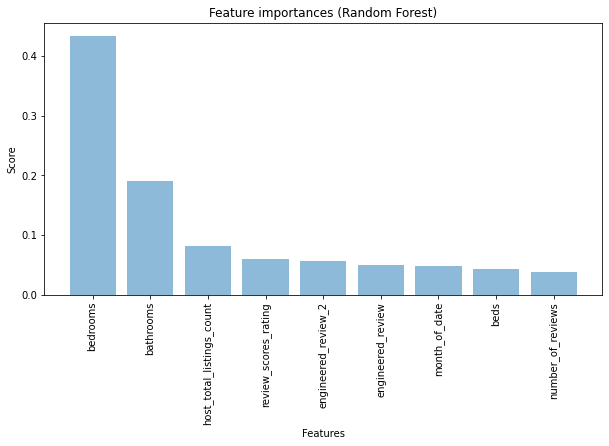

In [14]:
headers = ["name", "score"]
values = sorted(zip(X.columns, reg.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

In [18]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb.fit(X_train,y_train)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

MSE train: 2239.610, test: 2248.372
R^2 train: 0.798, test: 0.793


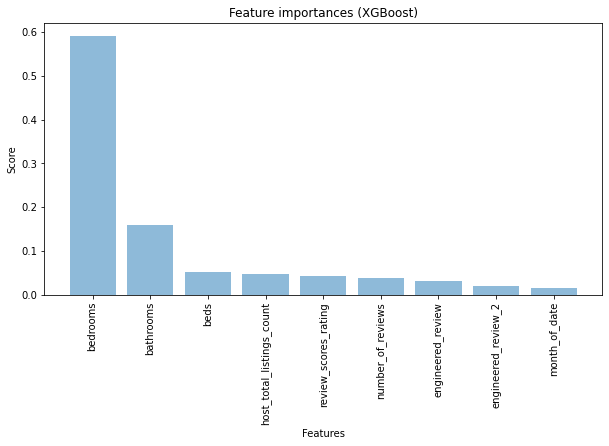

In [20]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 15 features
features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15]
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('feature importances XGB.png')
 
plt.show()

In [ ]:
df.sample(5)

In [ ]:
df['host_total_listings_count'].describe()